In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
import sklearn.datasets

import frame_whitening as fw
import frame_whitening.plot as fwplt
from frame_whitening import simulation as fws

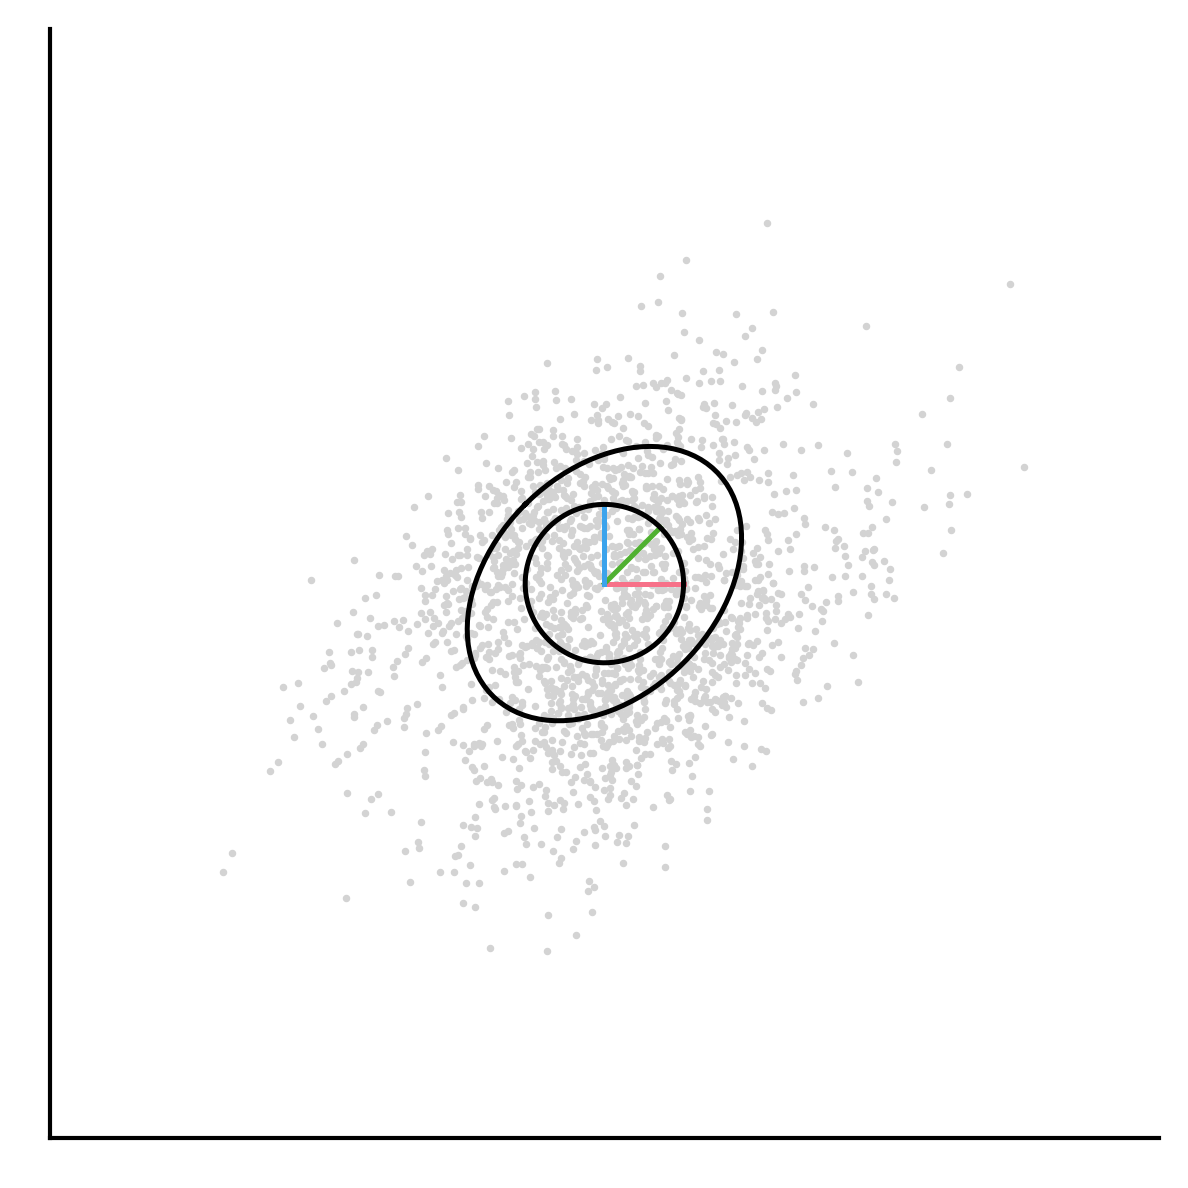

In [2]:
n_samples = 1000
N = 2
np.random.seed(42069)

X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=.28)

X = X - X.mean()

Cxx = np.array([
    [3, 1],
    [1, 3]
])

Lxx = sp.linalg.sqrtm(Cxx)

tmp = np.linalg.inv(np.cov(X.T))
L12 = np.linalg.cholesky(tmp)

Xw = X @ L12
X0 = Xw @ Lxx
np.cov(X0.T)


F = np.array([[1, 1/np.sqrt(2), 0],
              [0, 1/np.sqrt(2), 1]])

with sns.plotting_context("paper", font_scale=1.5):
  fig, ax = plt.subplots(1, 1, dpi=300, sharex="all", sharey="all")
  ax.scatter(*X0.T, color="lightgrey", s=1)
  ax.axis("square")
  fwplt.plot_ellipse(Cxx, n_pts=100, ax=ax, color="k", stdev=1.)

  cols = sns.color_palette("husl", 3)
  for i, f in enumerate(F.T):
    ax.plot([0, f[0]], [0, f[1]], color=cols[i])

  ax.scatter(*Xw.T, color="lightgrey", s=1)
  fwplt.plot_ellipse(np.eye(2), n_pts=100,  ax=ax, color="k", stdev=1.)
  axlim = 7
  ax.set(xticks=[], yticks=[], xlim=(-axlim,axlim), ylim=(-axlim, axlim))
  sns.despine()

  fig.savefig("tmp.pdf")

In [3]:
seed = 42069
np.random.seed(seed)
n, k = 2, 3
batch_size = 32
n_batch = 150
lr_g = 1E-1

theta = np.deg2rad(55)
V = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Cxx0 = V @ np.diag([4, 1]) @ V.T * 0.1
Cxx0 *= 50

# V, _ = np.linalg.qr(np.random.randn(n, n))
Cxx1 = V @ np.diag([3, 2]) @ V.T * 0.1
Cxx1 *= 30

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0, Cxx1]]
W = fw.get_mercedes_frame()
W = np.array([[0, 1, 1], [1, 1, 0]])
W = fw.normalize_frame(W)

g0 = np.array([0.01, 1.2, 0.25])
g, g_all, errors, variances = fws.simulate(cholesky_list, W, batch_size, n_batch, lr_g, g0=g0, online=False, seed=seed)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 20955.45it/s]


In [4]:
def get_variances(g, W, Cxx):
    N = W.shape[0]
    Ixx = np.eye(N)
    WGW = W @ np.diag(g) @ W.T
    M = np.linalg.inv(Ixx + WGW)
    Cyy = M @ Cxx @ M.T
    Czz = W.T @ Cyy @ W
    variances = np.diag(Czz)
    return variances

vars = []
g_all2 = [g for g in g_all]
for j, Cxx in enumerate([Cxx0, Cxx1]):
    for i in range(n_batch):
        vars.append(get_variances(g_all2.pop(0), W, Cxx))

vars = np.stack(vars)

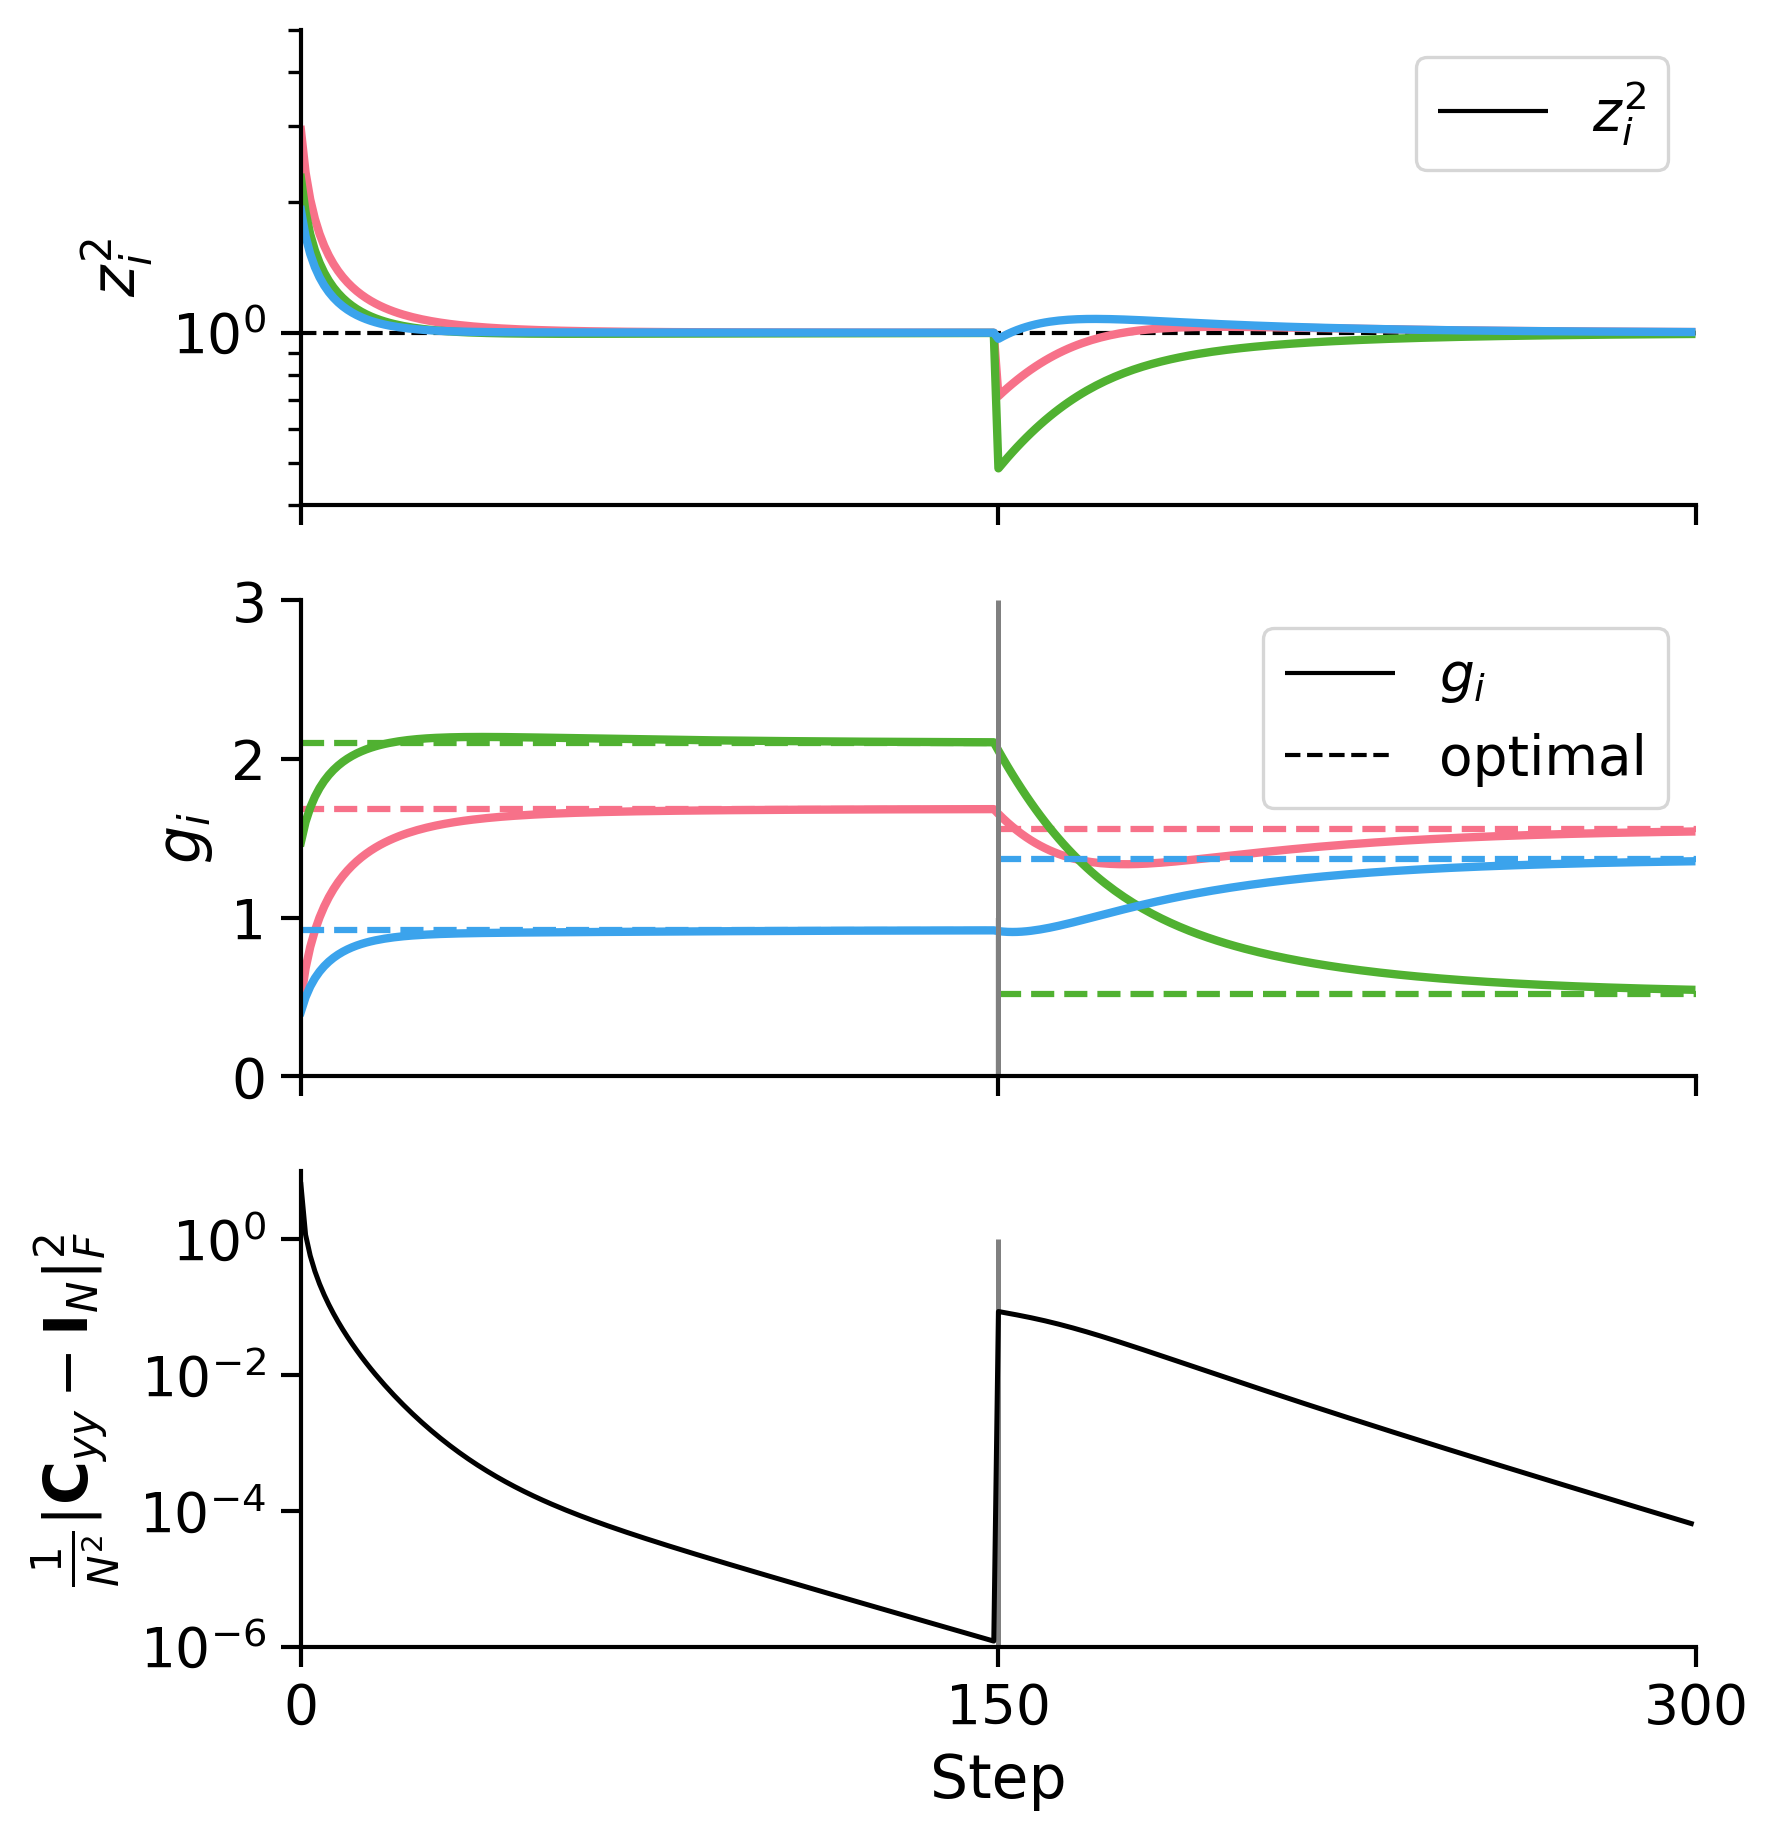

In [5]:
with sns.plotting_context("paper", font_scale=1.5):

    cols = sns.color_palette("husl", 3)
    fig, ax = plt.subplots(3, 1, figsize=(6, 7), sharex="all", dpi=300)

    for i in range(k):
        ax[0].plot(vars[:,i], color=cols[i], linewidth=2)

    # dummy line for legend
    ax[0].vlines(n_batch, 0, 0, color="k", ls="-", 
    linewidth=1, label=r"$z_i^2$", zorder=-1)
    ax[0].hlines(
        1, 0, 2*n_batch, color="k", linestyle="--", linewidth=1.,  zorder=-1)


    g_opt0 = fws.get_g_opt(W, Cxx0)
    g_opt1 = fws.get_g_opt(W, Cxx1)
    g_opt = [g_opt0, g_opt1]

    # dummy line for legend
    ax[1].vlines(
        n_batch, 0, 1, color="k", ls="-", linewidth=1, label=r"$g_i$", zorder=-1)
    ax[1].hlines(
        g_opt[0], 0, 0, color="k", linestyle="--",
        linewidth=1., label="optimal", zorder=-1)

    for i in range(k):
        ax[1].plot(g_all[:,i], color=cols[i], linewidth=2)
        ax[1].hlines(g_opt0[i], 0, n_batch, color=cols[i], linestyle='--', lw=1.5)
        ax[1].hlines(g_opt1[i], n_batch, 2*n_batch, color=cols[i], linestyle='--', lw=1.5)
    ax[1].vlines(n_batch, 0, 3, color="grey", linestyle='-')
    ax[2].vlines(n_batch, 1E-10, 1, color="grey", linestyle='-')

    ax[0].set(ylabel=r"$z_i^2$", yscale="log", ylim=(.4, 5))
    ax[0].legend(loc="upper right")
    ax[1].set(ylabel=r"$g_i$", xlim=(0, n_batch * len(cholesky_list)), ylim=(0, 3),
    xticks=(0, n_batch, 2*n_batch))
    ax[2].plot(errors, "k")

    ax[2].set(ylabel=r"$\frac{1}{N^2}\|{\bf C}_{yy} - {\bf I}_N\|_{F}^2$", xlabel="Step", 
    yscale="log", ylim=(1E-6, 10))
    ax[1].legend(loc="upper right")
    sns.despine()